In [1]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from my_functions import *

In [2]:
filters_tags = load_filter_tags()

In [3]:
tcurves = load_tcurves(filters_tags)

In [4]:
w_central = central_wavelength(tcurves)

In [5]:
def nb_fwhm_here(nb_ind):
    
    t = tcurves['t'][nb_ind]
    w = tcurves['w'][nb_ind]
    
    tmax = np.amax(t)
    
    for i in range(len(w)):
        if t[i] < tmax/2:
            pass
        else:
            w_min = w[i]
            break
            
    for i in range(len(w)):
        if t[-i] < tmax/2:
            pass
        else:
            w_max = w[-i]
            break
            
    return w_max, w_min            

In [6]:
errors = np.load('npy/errors5Sigma.npy')

In [7]:
def mag_error(m,fil,pm):
    w = np.array(w_central)
    ww = w[fil]
    f = mag_to_flux(m, ww)
    if pm == '+':
        return 2.5 * np.log10( (f+3*errors[fil,1]) / f )
    if pm == '-':
        return 2.5 * np.log10( (f-3*errors[fil,1]) / f )
    else:
        print('ERROR: No + or - specified.')

In [8]:
def plot_this(bb_ind, nb_ind, plot_error = False):
    w = np.array(w_central)

    c = 299792458 *100 # c in cgs
    mag = np.zeros(pm.shape)

    for i in range(pm.shape[1]):
        mag[:,i] = -2.5*np.log10(pm[:,i] * w**2/c *1e-8) - 48.60

    print(tcurves['tag'][nb_ind])
    print(tcurves['tag'][bb_ind])

    bb = mag[bb_ind,:] 
    nb = mag[nb_ind,:]
    
    bbnb = bb - nb
    
    x = np.linspace(18,28,1000)
    
    error_curve = (
        np.sqrt( mag_error(x, nb_ind,'+')**2 + mag_error(x, bb_ind,'-')**2 )
        + np.nanmedian(bbnb)
    )

    ## Color cut
    Lya_w = 1215.67
    z = w_central[nb_ind]/Lya_w - 1
    EW     = 30 * (1+z) # A
    w_max_nb, w_min_nb = nb_fwhm_here(nb_ind)
    fwhm = w_max_nb - w_min_nb
    
    print('z = ' + str(z))
    
    color_cut = 2.5*np.log10(EW/fwhm + 1)

    x_color_cut = np.linspace(15,31,100)
    y_color_cut = np.ones(100) * color_cut
    ##
    
    z_max = w_max_nb/Lya_w - 1
    z_min = w_min_nb/Lya_w - 1
    
    z_Arr = mock['redshift_Lya_Arr']
    
    isz = []
    for z in z_Arr:
        if z < z_max and z > z_min:
            isz.append(True)
        else:
            isz.append(False)
            
    nb_rightz    =    nb[np.where(isz)]
    bbnb_rightz  =  bbnb[np.where(isz)]
    islae_rightz = islae[np.where(isz)]
    
    
    ##### PLOT ####
    
    plt.figure(figsize=(12,8))

    plt.scatter(nb[np.where(islae == False)],  bbnb[np.where(islae == False)],
                edgecolor = 'purple', facecolor='None')
    plt.scatter(nb[np.where(islae == True )],  bbnb[np.where(islae == True )],
                marker='s', edgecolor='green', facecolor='None')
    
    plt.scatter(nb_rightz[np.where(islae_rightz == False)],
                bbnb_rightz[np.where(islae_rightz == False)],
                edgecolor = 'purple', facecolor='purple', label='OII')
    plt.scatter(nb_rightz[np.where(islae_rightz == True )],
                bbnb_rightz[np.where(islae_rightz == True )],
                marker='s', edgecolor='green', facecolor='green', label='LAE')
    
    plt.plot(x_color_cut, y_color_cut, 'orange', label='EW$_0$ = 30 $\AA$')
    if plot_error == True: plt.plot(x, error_curve, 'r', label='$\sigma$')

    plt.ylabel('bb-nb', size='15')
    plt.xlabel('nb'   , size='15')

    plt.ylim( (-3  ,  3 ) )
    plt.xlim( ( 19 ,  27) )
    
    plt.legend()

    plt.show()
    
#     print('candidates: '+ str(np.where(bbnb < -5*color_cut)))

J0410
gSDSS
z = 2.3861454908731714


<ipython-input-7-0a852b291e1e>:8: RuntimeWarning: invalid value encountered in log10
  return 2.5 * np.log10( (f-3*errors[fil,1]) / f )


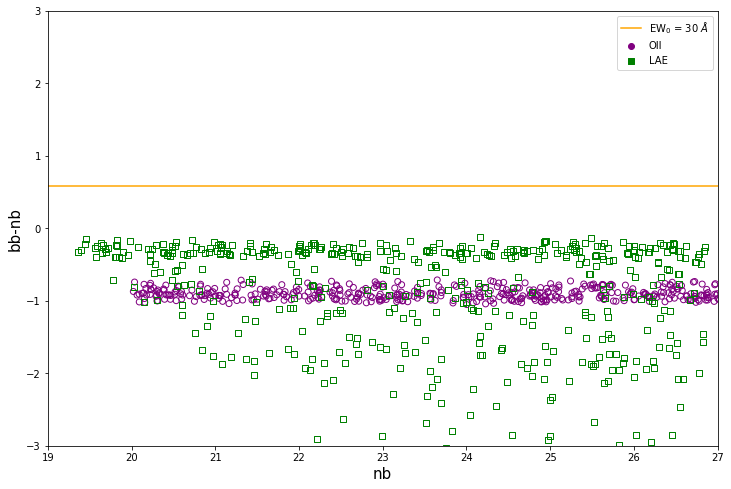

J0420
gSDSS
z = 2.4632330559557145


<ipython-input-7-0a852b291e1e>:8: RuntimeWarning: invalid value encountered in log10
  return 2.5 * np.log10( (f-3*errors[fil,1]) / f )


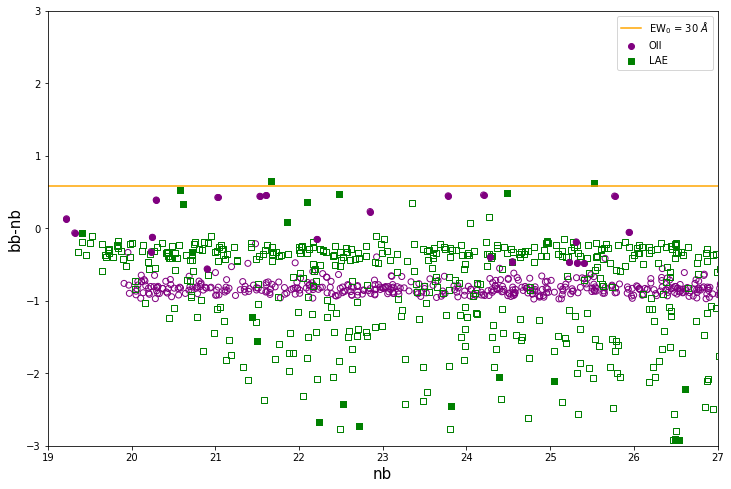

J0430
gSDSS
z = 2.5462498566723273


<ipython-input-7-0a852b291e1e>:8: RuntimeWarning: invalid value encountered in log10
  return 2.5 * np.log10( (f-3*errors[fil,1]) / f )


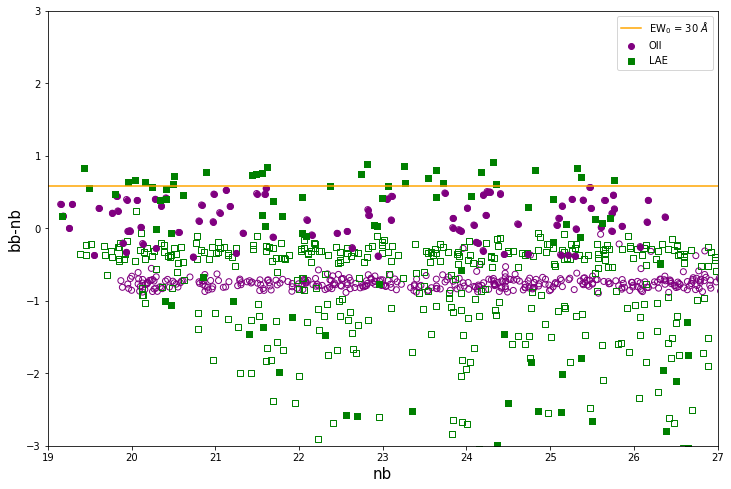

J0440
gSDSS
z = 2.6266743524189327


<ipython-input-7-0a852b291e1e>:8: RuntimeWarning: invalid value encountered in log10
  return 2.5 * np.log10( (f-3*errors[fil,1]) / f )


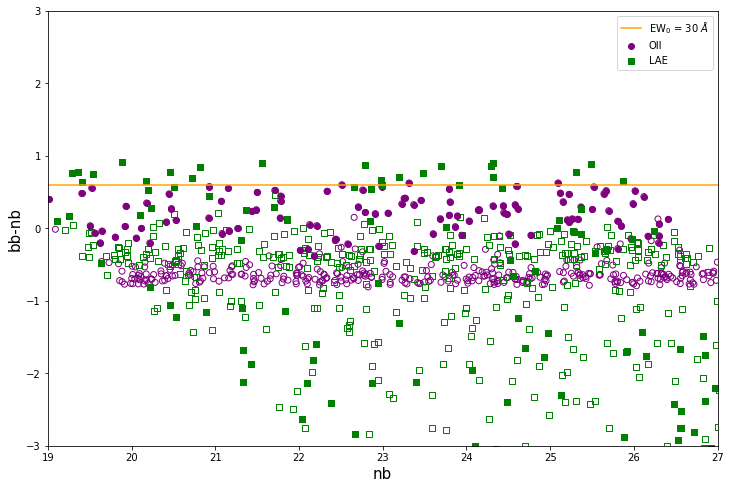

J0450
gSDSS
z = 2.71421584882449


<ipython-input-7-0a852b291e1e>:8: RuntimeWarning: invalid value encountered in log10
  return 2.5 * np.log10( (f-3*errors[fil,1]) / f )


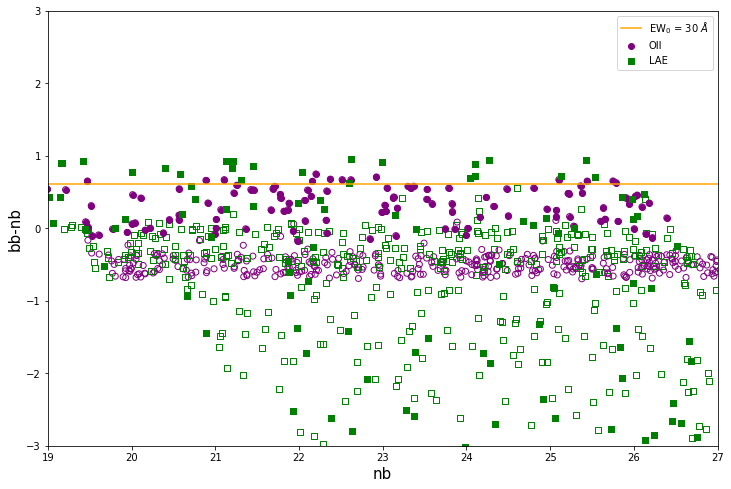

J0460
gSDSS
z = 2.7914193936309024


<ipython-input-7-0a852b291e1e>:8: RuntimeWarning: invalid value encountered in log10
  return 2.5 * np.log10( (f-3*errors[fil,1]) / f )


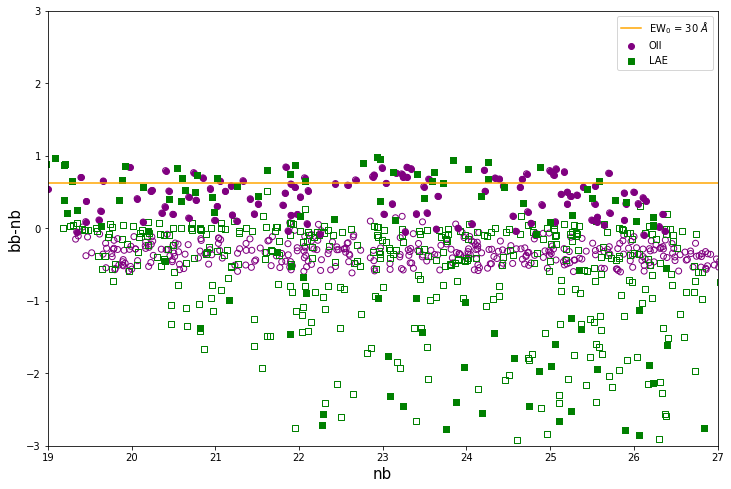

J0470
gSDSS
z = 2.870496420399379


<ipython-input-7-0a852b291e1e>:8: RuntimeWarning: invalid value encountered in log10
  return 2.5 * np.log10( (f-3*errors[fil,1]) / f )


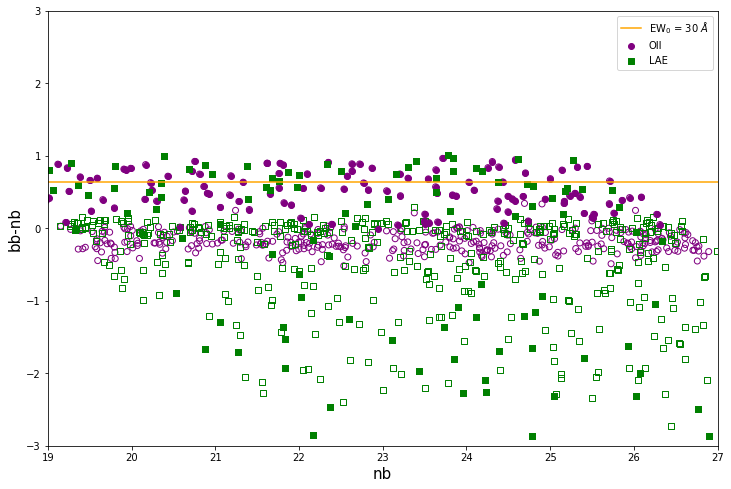

J0480
gSDSS
z = 2.9556365958025044


<ipython-input-7-0a852b291e1e>:8: RuntimeWarning: invalid value encountered in log10
  return 2.5 * np.log10( (f-3*errors[fil,1]) / f )


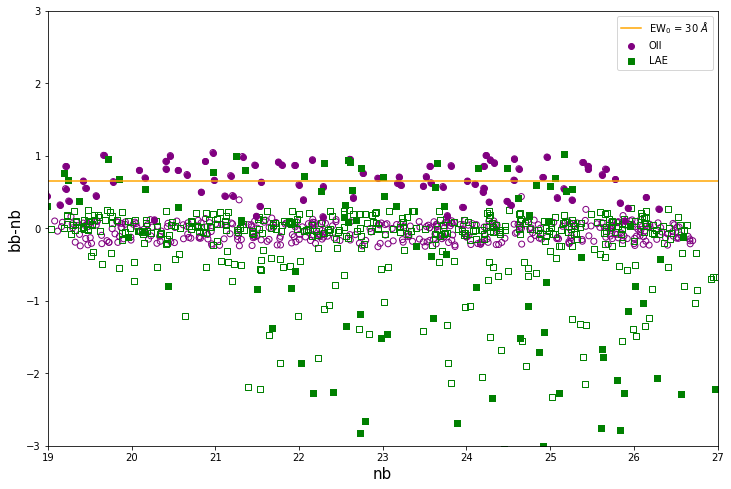

J0490
gSDSS
z = 3.0364388599610033


<ipython-input-7-0a852b291e1e>:8: RuntimeWarning: invalid value encountered in log10
  return 2.5 * np.log10( (f-3*errors[fil,1]) / f )


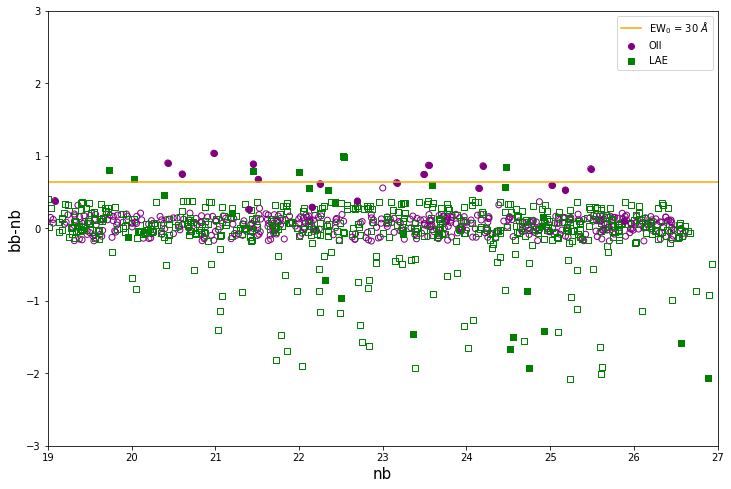

J0500
gSDSS
z = 3.1178645713491955


<ipython-input-7-0a852b291e1e>:8: RuntimeWarning: invalid value encountered in log10
  return 2.5 * np.log10( (f-3*errors[fil,1]) / f )


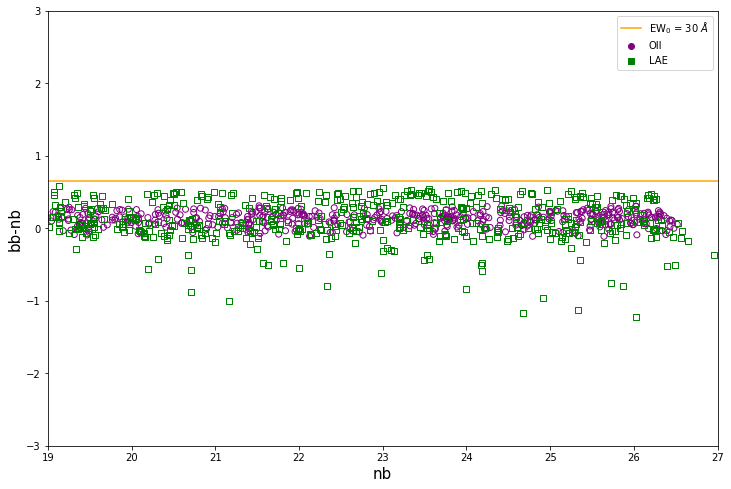

In [9]:
f_name = 'Source_cats/Source_cat_1000b.npy'
mock = np.load( f_name, allow_pickle=True ).item()
islae = mock['LAE']
EW_Arr = mock['EW_Arr']

pm = np.load('npy/pm_1000b.npy')
for i in range(4,14):
    plot_this(-3, i)

J0410
gSDSS
z = 2.3861454908731714


<ipython-input-8-beb34aa1d1b1>:8: RuntimeWarning: invalid value encountered in log10
  mag[:,i] = -2.5*np.log10(pm[:,i] * w**2/c *1e-8) - 48.60


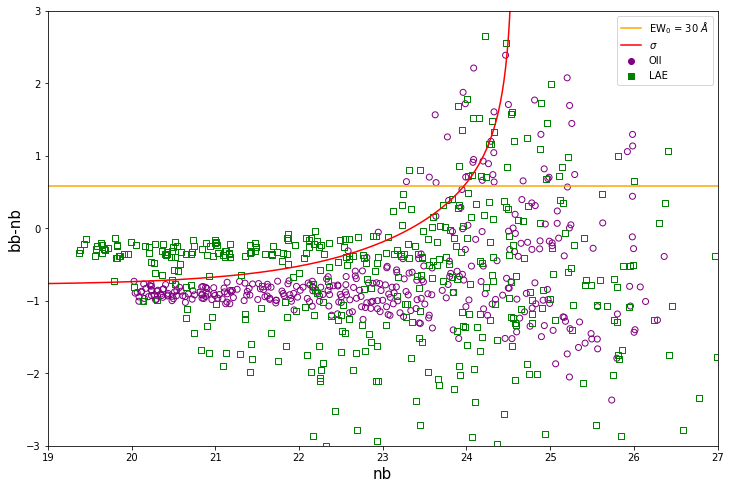

<ipython-input-8-beb34aa1d1b1>:8: RuntimeWarning: invalid value encountered in log10
  mag[:,i] = -2.5*np.log10(pm[:,i] * w**2/c *1e-8) - 48.60


J0420
gSDSS
z = 2.4632330559557145


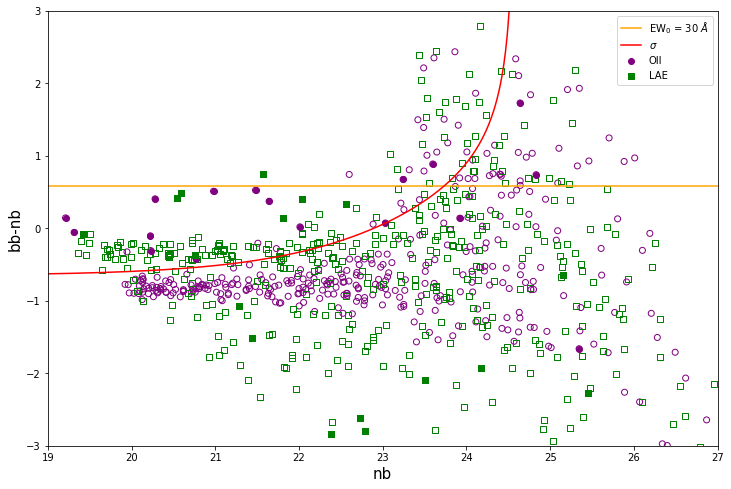

<ipython-input-8-beb34aa1d1b1>:8: RuntimeWarning: invalid value encountered in log10
  mag[:,i] = -2.5*np.log10(pm[:,i] * w**2/c *1e-8) - 48.60


J0430
gSDSS
z = 2.5462498566723273


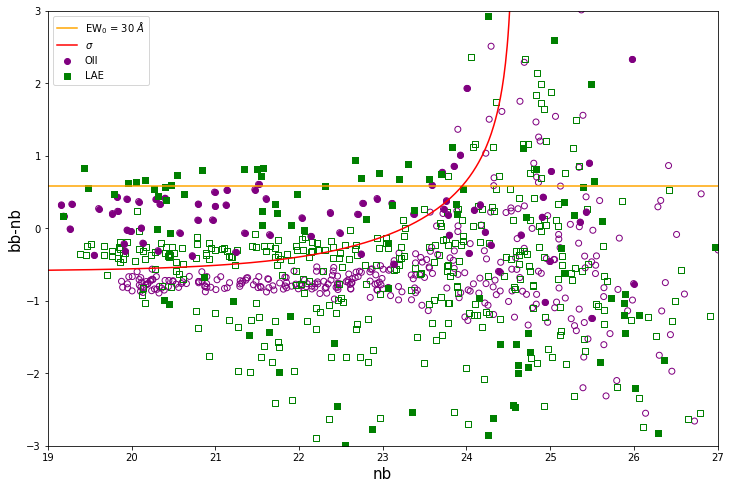

<ipython-input-8-beb34aa1d1b1>:8: RuntimeWarning: invalid value encountered in log10
  mag[:,i] = -2.5*np.log10(pm[:,i] * w**2/c *1e-8) - 48.60


J0440
gSDSS
z = 2.6266743524189327


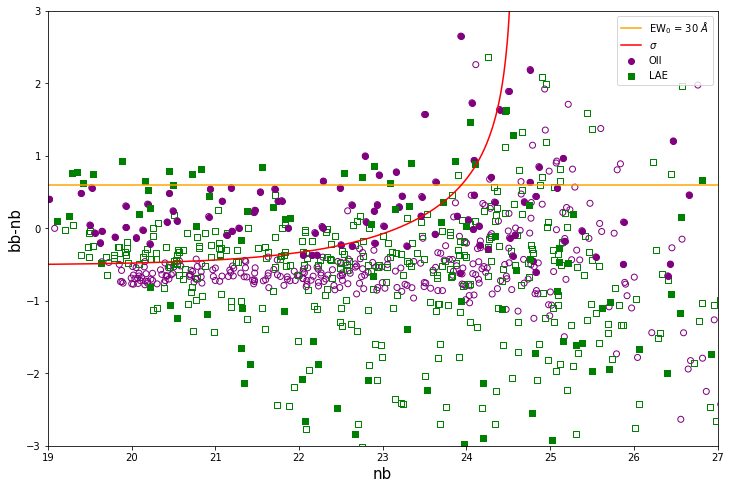

J0450
gSDSS
z = 2.71421584882449


<ipython-input-8-beb34aa1d1b1>:8: RuntimeWarning: invalid value encountered in log10
  mag[:,i] = -2.5*np.log10(pm[:,i] * w**2/c *1e-8) - 48.60


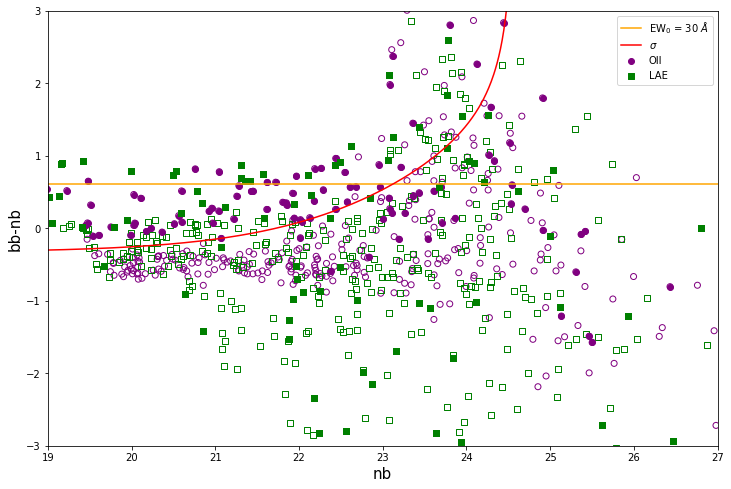

<ipython-input-8-beb34aa1d1b1>:8: RuntimeWarning: invalid value encountered in log10
  mag[:,i] = -2.5*np.log10(pm[:,i] * w**2/c *1e-8) - 48.60


J0460
gSDSS
z = 2.7914193936309024


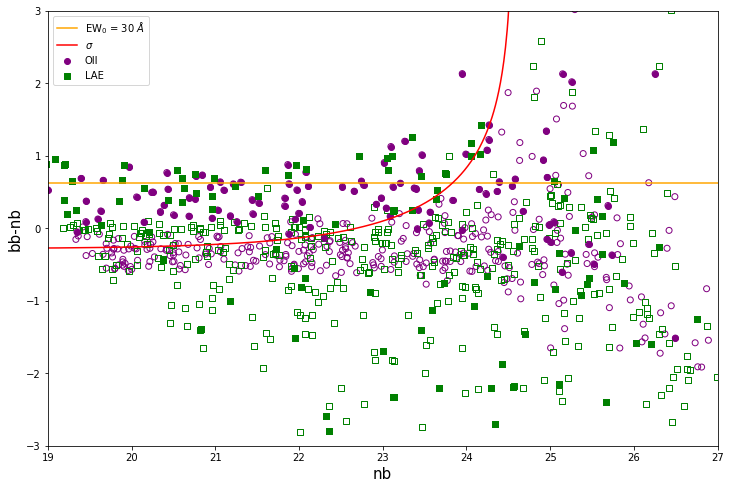

<ipython-input-8-beb34aa1d1b1>:8: RuntimeWarning: invalid value encountered in log10
  mag[:,i] = -2.5*np.log10(pm[:,i] * w**2/c *1e-8) - 48.60


J0470
gSDSS
z = 2.870496420399379


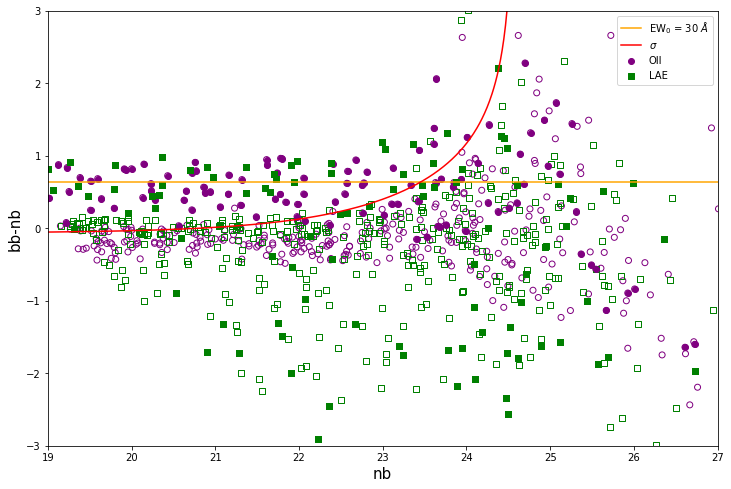

<ipython-input-8-beb34aa1d1b1>:8: RuntimeWarning: invalid value encountered in log10
  mag[:,i] = -2.5*np.log10(pm[:,i] * w**2/c *1e-8) - 48.60


J0480
gSDSS
z = 2.9556365958025044


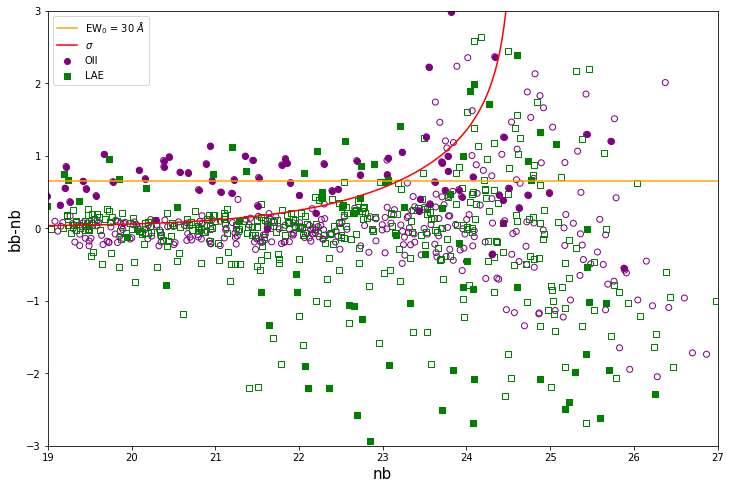

<ipython-input-8-beb34aa1d1b1>:8: RuntimeWarning: invalid value encountered in log10
  mag[:,i] = -2.5*np.log10(pm[:,i] * w**2/c *1e-8) - 48.60


J0490
gSDSS
z = 3.0364388599610033


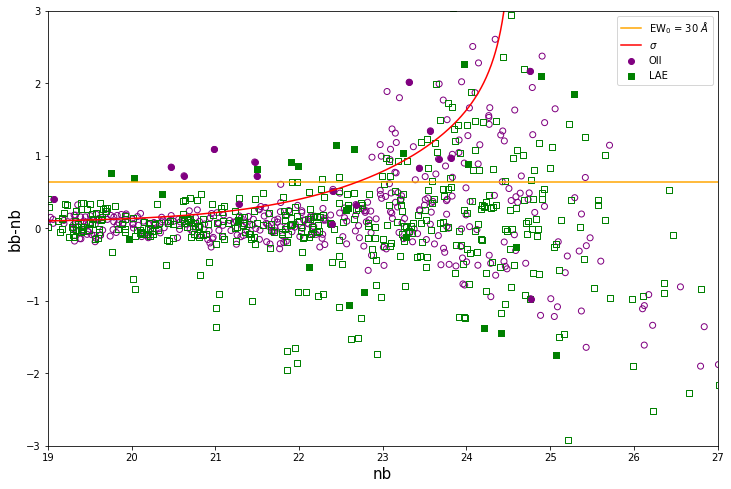

<ipython-input-8-beb34aa1d1b1>:8: RuntimeWarning: invalid value encountered in log10
  mag[:,i] = -2.5*np.log10(pm[:,i] * w**2/c *1e-8) - 48.60


J0500
gSDSS
z = 3.1178645713491955


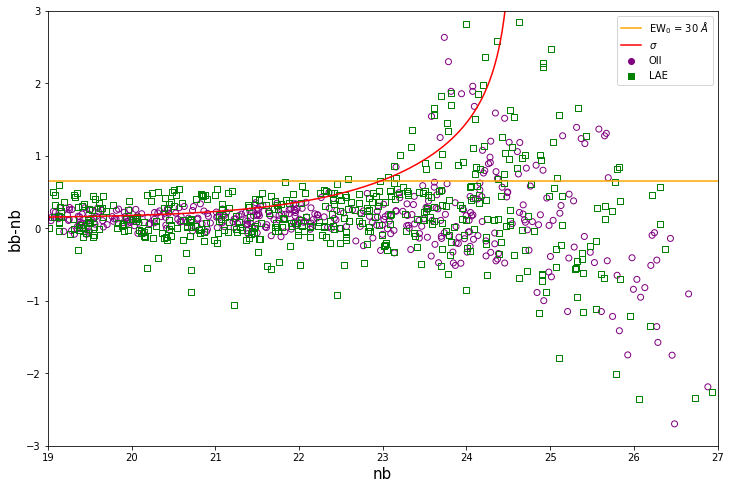

In [10]:
f_name = 'Source_cats/Source_cat_1000b.npy'
mock = np.load( f_name, allow_pickle=True ).item()
islae = mock['LAE']
EW_Arr = mock['EW_Arr']

pm = np.load('npy/pm_e1000b.npy')
for i in range(4,14):
    plot_this(-3, i, True)

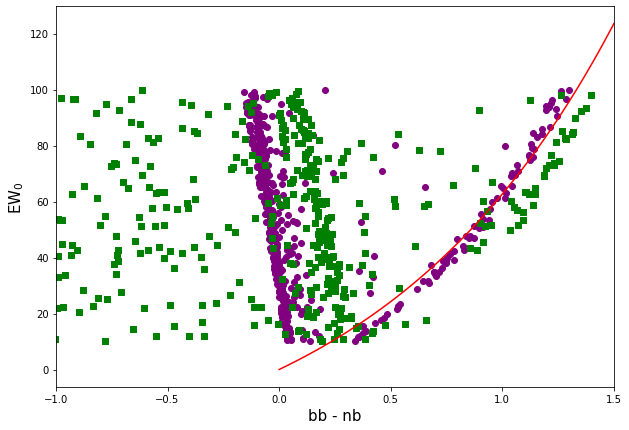

In [11]:
f_name = 'Source_cats/Source_cat_1000b.npy'
mock = np.load( f_name, allow_pickle=True ).item()
islae = mock['LAE']
EW_Arr = mock['EW_Arr']
pm = np.load('npy/pm_1000b.npy')

bb_ind = -3 #gSDSS
nb_ind = 6 #J0490

bb = flux_to_mag(pm[bb_ind,:], np.array(w_central[bb_ind]))
nb = flux_to_mag(pm[nb_ind,:], np.array(w_central[nb_ind]))
    
bbnb = bb - nb

lae_median = np.nanmedian(bbnb[islae])
oii_median = np.nanmedian(bbnb[np.invert(islae)])

## Color cut
Lya_w = 1215.67
z = w_central[nb_ind]/Lya_w - 1
EW     = 30 * (1+z) # A
w_max_nb, w_min_nb = nb_fwhm_here(nb_ind)
fwhm = w_max_nb - w_min_nb

color_cut = 2.5*np.log10(EW/fwhm + 1)

candidates = (bbnb > color_cut)

def ew_theo(bbnb_x, fwhm, z):
    return (10**(bbnb_x/2.5) - 1) * fwhm/(1+z)

bbnb_x = np.linspace(0, 1.5, 100)

plt.figure(figsize=(10,7))
# plt.scatter(bbnb, EW_Arr)
# plt.scatter(bbnb[candidates], EW_Arr[candidates])
plt.scatter(bbnb[np.where(islae == False)] - oii_median,
                EW_Arr[np.where(islae == False)],
                edgecolor = 'purple', facecolor='purple')
plt.scatter(bbnb[np.where(islae == True )] - lae_median,
                EW_Arr[np.where(islae == True)],
                marker='s', edgecolor='green', facecolor='green')
plt.plot(bbnb_x, ew_theo(bbnb_x, fwhm, z), c='red')
plt.ylabel('EW$_0$', size = 15)
plt.xlabel('bb - nb', size = 15)
plt.xlim((-1, 1.5))
plt.show()

In [12]:
bb_fwhm = [
    nb_fwhm(tcurves, -4, True),
    nb_fwhm(tcurves, -3, True),
    nb_fwhm(tcurves, -2, True),
    nb_fwhm(tcurves, -1, True)
]

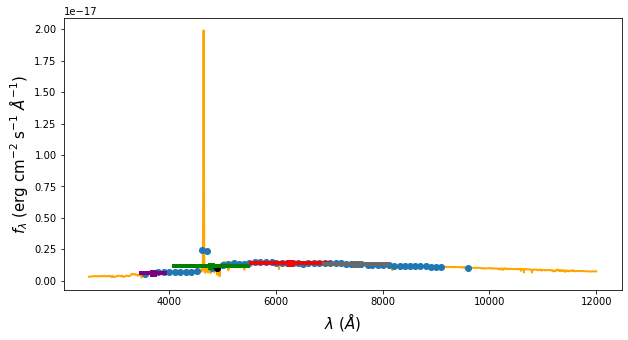

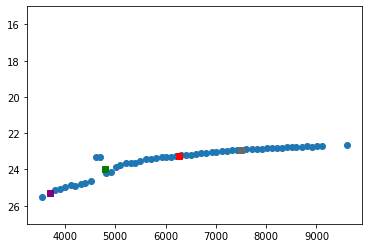

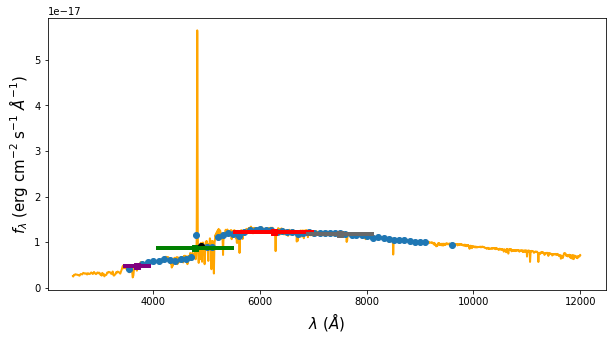

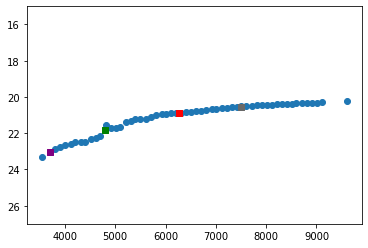

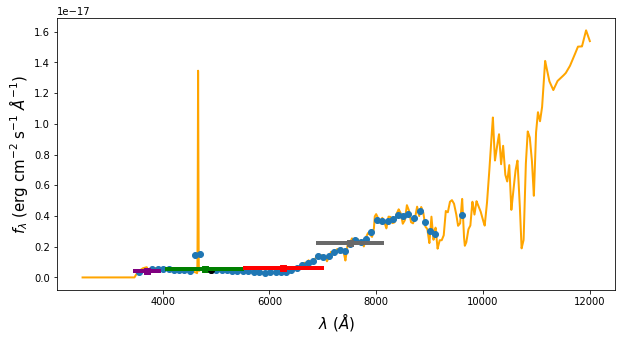

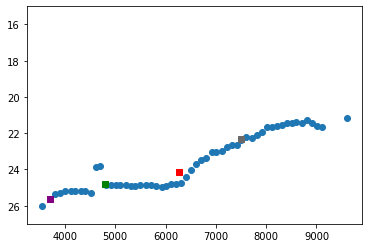

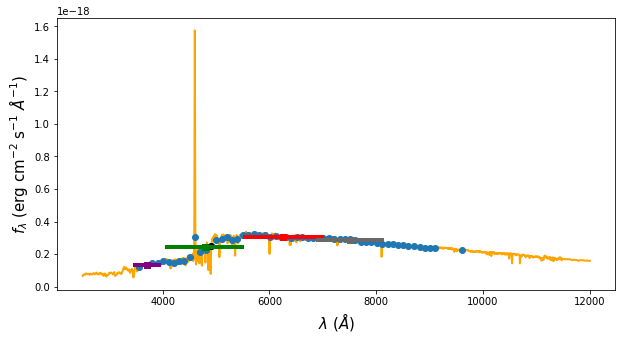

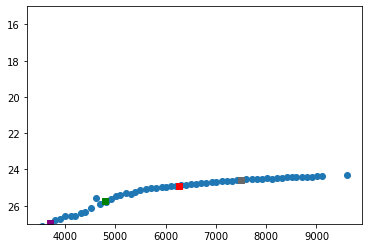

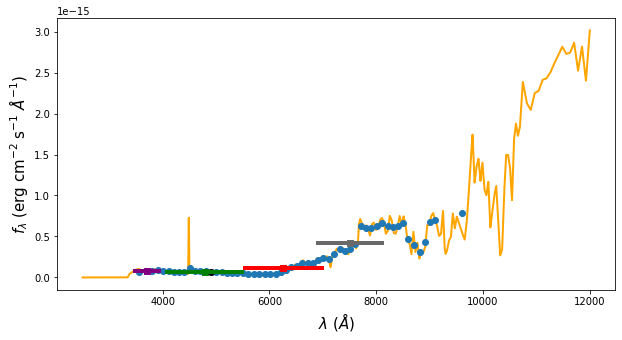

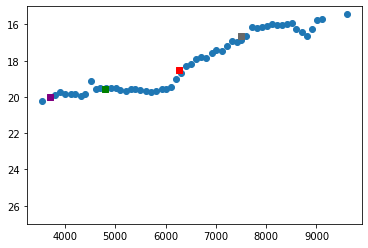

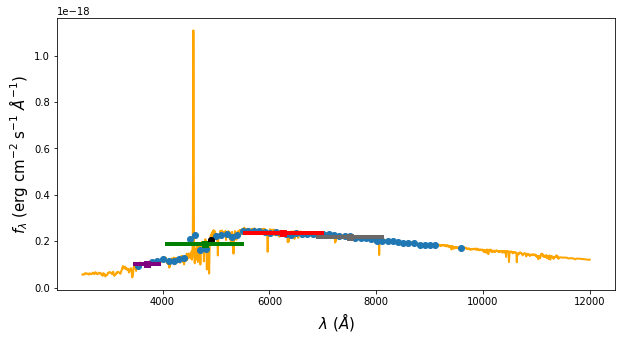

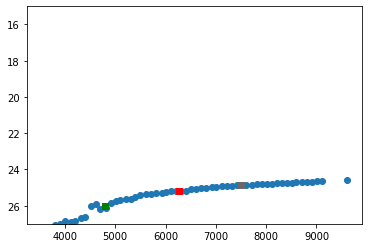

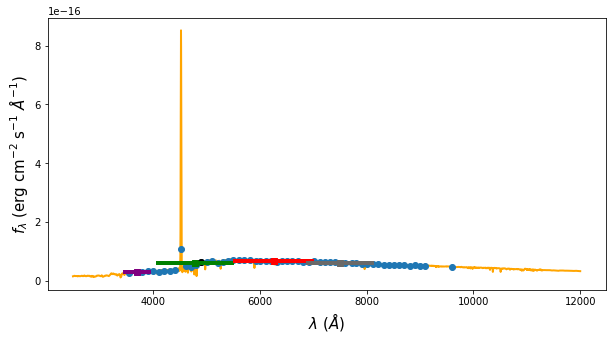

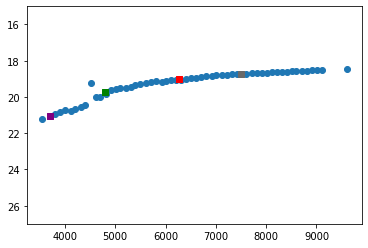

In [13]:
candidates = [40,  53,  93, 157, 219, 296, 463]

for mock_n in candidates:
    pm_plot = pm[:,mock_n]

    plt.figure(figsize=(10,5))
    plt.plot( mock['w_Arr'], mock['SEDs'][mock_n], c='orange', lw=2, zorder=-1)
    plt.scatter(w_central[:-3], pm_plot[:-3])

    plt.scatter(w_central[-4], pm_plot[-4], c='purple' , marker='s')
    plt.scatter(w_central[-3], pm_plot[-3], c='green'  , marker='s')
    plt.scatter(w_central[-2], pm_plot[-2], c='red'    , marker='s')
    plt.scatter(w_central[-1], pm_plot[-1], c='dimgray', marker='s')

    plt.errorbar(w_central[-4], pm_plot[-4], xerr=bb_fwhm[-4]/2, fmt='none', color='purple' , elinewidth=4)
    plt.errorbar(w_central[-3], pm_plot[-3], xerr=bb_fwhm[-3]/2, fmt='none', color='green'  , elinewidth=4)
    plt.errorbar(w_central[-2], pm_plot[-2], xerr=bb_fwhm[-2]/2, fmt='none', color='red'    , elinewidth=4)
    plt.errorbar(w_central[-1], pm_plot[-1], xerr=bb_fwhm[-1]/2, fmt='none', color='dimgray', elinewidth=4)
    plt.scatter(w_central[12], pm_plot[12], color='black')

    #plt.yscale('log')

    plt.xlabel('$\lambda\ (\AA)$', size=15)
    plt.ylabel('$f_\lambda$ (erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$)', size=15)    

    plt.show()
    
    plt.figure()
    
    pm_plot = flux_to_mag(pm_plot, np.array(w_central))
    
    plt.ylim((15,27))

    plt.scatter(w_central[:-3], pm_plot[:-3])
    plt.scatter(w_central[-4], pm_plot[-4], c='purple' , marker='s')
    plt.scatter(w_central[-3], pm_plot[-3], c='green'  , marker='s')
    plt.scatter(w_central[-2], pm_plot[-2], c='red'    , marker='s')
    plt.scatter(w_central[-1], pm_plot[-1], c='dimgray', marker='s')
    plt.gca().invert_yaxis()
    plt.show()